### G2Net Gravitational Wave Detection
#### Tony Davis and Andy Cheng

# Note:

The data for this notebook is included below:

Pure numpy data from competition site: https://www.kaggle.com/c/g2net-gravitational-wave-detection/data


# Download necessary packages for signal pre-processing


In [ ]:
!python -m pip install gwpy # install gwpy package for data pre-processing

  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!python -m pip uninstall matplotlib # using this version of matplotlib for plotting data
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.4.2
Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.2
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy

# Import Necessary Packages


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras.layers as L
from sklearn.model_selection import train_test_split
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

import os
directory = 'C:/Users/acdav/Documents/GitHub/G2Net Gravitational Wave Detection/' #your directory here
os.chdir(directory)

# Get training labels and submission file ready for competition. Set training and test paths for RGB images creation


Adapted from https://www.kaggle.com/mrigendraagrawal/tf-g2net-eda-and-starter

In [ ]:
train_labels = pd.read_csv('../training_labels.csv')
sample_submission = pd.read_csv('../sample_submission.csv')

train_path = list(train_labels['id'])
for i in range(len(train_path)):
    train_path[i] = '../train/' +train_path[i][0]+'/'+train_path[i][1]+'/'+train_path[i][2]+'/' + train_path[i] + '.npy'
    
test_path = list(sample_submission['id'])
for i in range(len(test_path)):
    test_path[i] = '../test/' +test_path[i][0]+'/'+test_path[i][1]+'/'+test_path[i][2]+'/' + test_path[i] + '.npy'


# Convert Signals to Images for CNN Training


## Read & plot files

Adapted from https://www.kaggle.com/mistag/data-preprocessing-with-gwpy/execution

Let's define helper functions to read numpy data and convert into gwpy TimeSeries format and plot the data. All the files are 2 second recordings at 2048Hz sample rate from the 3 gravitational wave detectors (LIGO Hanford, LIGO Livingston, and Virgo).

This cell below is the standard LIGO preprocessing. It loads the data, whitens and applies a bandpass filter to reduce noise. Then uses q_transform to createa spectrogram.

In [ ]:
def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()

def read_file(fname):
    data = np.load(fname)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def preprocess(d1, d2, d3, bandpass=True, lf=35, hf=350):
    white_d1 = d1.whiten(window=("tukey",0.2))
    white_d2 = d2.whiten(window=("tukey",0.2))
    white_d3 = d3.whiten(window=("tukey",0.2))
    if bandpass: # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: # only whiten
        return white_d1, white_d2, white_d3

def create_rgb(fname):
    r1, r2, r3 = read_file(fname)
    p1, p2, p3 = preprocess(r1, r2, r3)
    hq1 = p1.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq2 = p2.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq3 = p3.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    img = np.zeros([hq1.shape[0], hq1.shape[1], 3], dtype=np.uint8)
    scaler = MinMaxScaler()
    img[:,:,0] = 255*scaler.fit_transform(hq1)
    img[:,:,1] = 255*scaler.fit_transform(hq2)
    img[:,:,2] = 255*scaler.fit_transform(hq3)
    return Image.fromarray(img).rotate(90, expand=1).resize((760,760))

Q_RANGE=(16,32)
F_RANGE=(30,400)

Visualize a file (Note that the image directories need to be changed when this notebook is run on a different Google account):

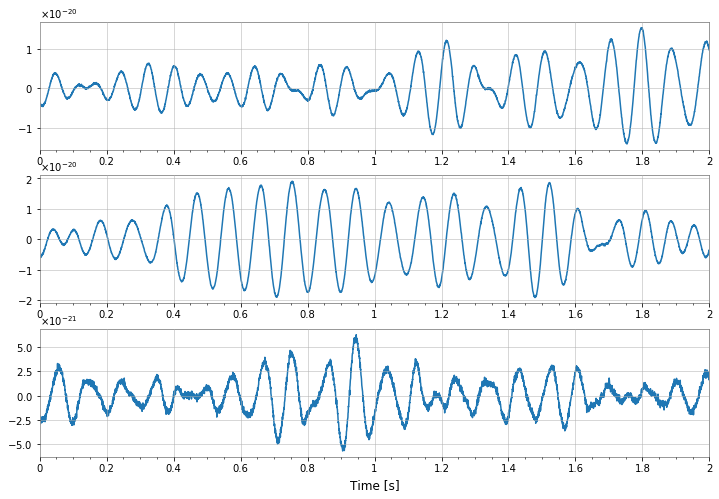

In [ ]:
# this file (numpy data) is downloaded from the Kaggle G2Net Competition website, and uploaded to the local runtime on Colab.
d1, d2, d3 = read_file('/content/sample_data/000a5b6e5c.npy') # data can be obtained here: https://www.kaggle.com/c/g2net-gravitational-wave-detection/data
plot_time_data(d1, d2, d3)

## Preprocess
Then we will follow the general processing steps outlined in [this article](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e):  
* Apply a window function (Tukey - tapered cosine window) to suppress spectral leakage
* Whiten the spectrum
* Bandpass the signal

### Apply window function
The Tukey window looks like this:

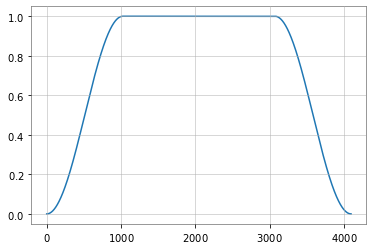

In [ ]:
window = signal.tukey(4096)
plt.plot(window);

Let's look at the signals of the 3 detectors after windowing:

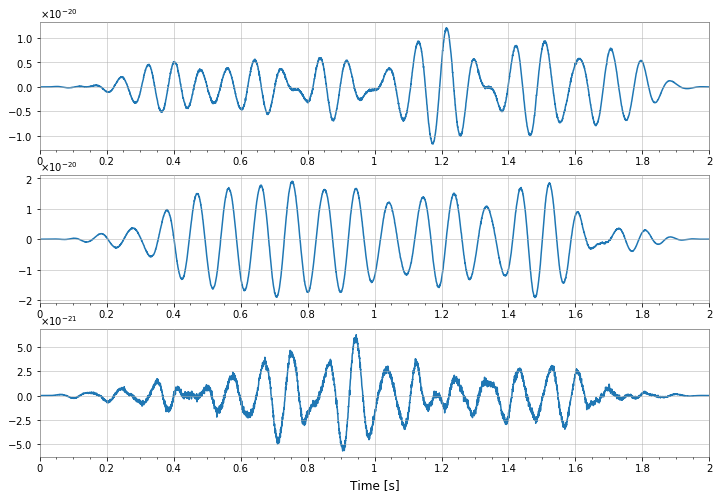

In [ ]:
d1, d2, d3 = d1*window, d2*window, d3*window
plot_time_data(d1, d2, d3)

Take a look at the spectrums - there is a lot of low frequency noise:

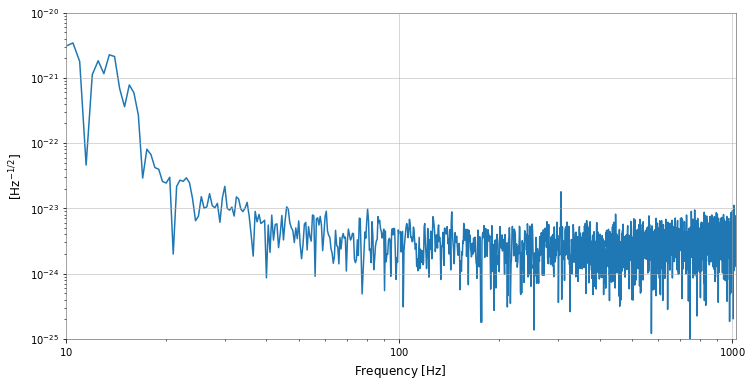

In [ ]:
fig2 = d1.asd(fftlength=2).plot(figsize=[12, 6]) # detector 1
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

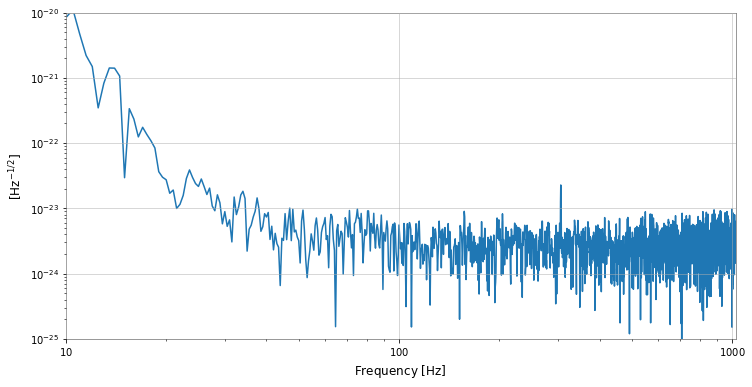

In [ ]:
fig2_1 = d2.asd(fftlength=2).plot(figsize=[12, 6]) # detector 2
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

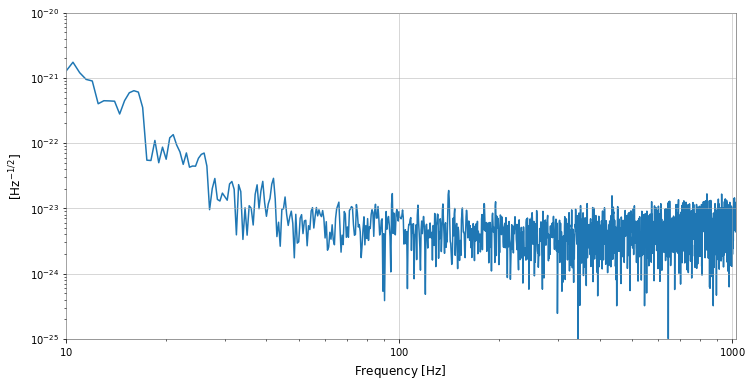

In [ ]:
fig2_2 = d3.asd(fftlength=2).plot(figsize=[12, 6]) # detector 3
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

The data can be easily highpassed or filtered (here with 15Hz highpass frequency):

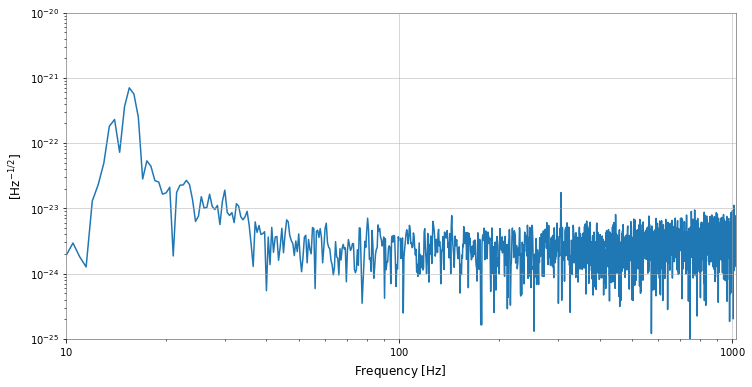

In [ ]:
fig2b = d1.highpass(15).asd(fftlength=2).plot(figsize=[12, 6]) # detector 1
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

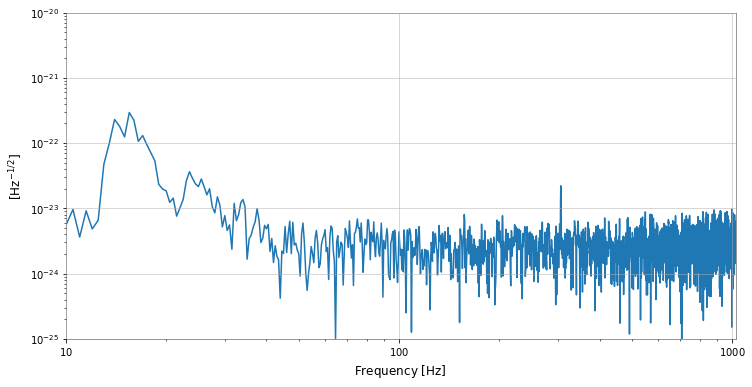

In [ ]:
fig2b_1 = d2.highpass(15).asd(fftlength=2).plot(figsize=[12, 6]) # detector 2
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

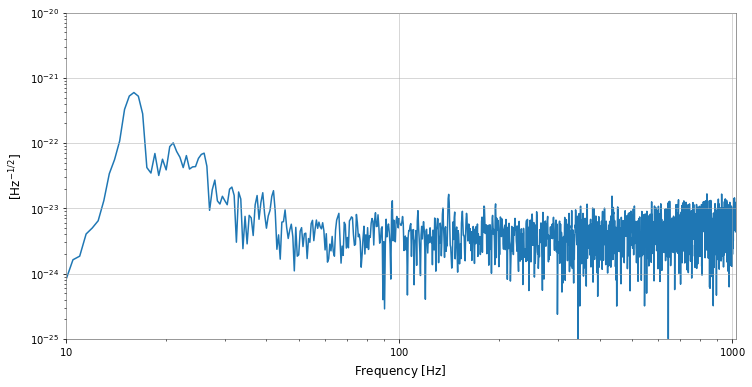

In [ ]:
fig2b_2 = d3.highpass(15).asd(fftlength=2).plot(figsize=[12, 6]) # detector 3
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

### Spectral whitening and bandpass filtering
This can be done with GWpy. Here's the effect on the d1 data:

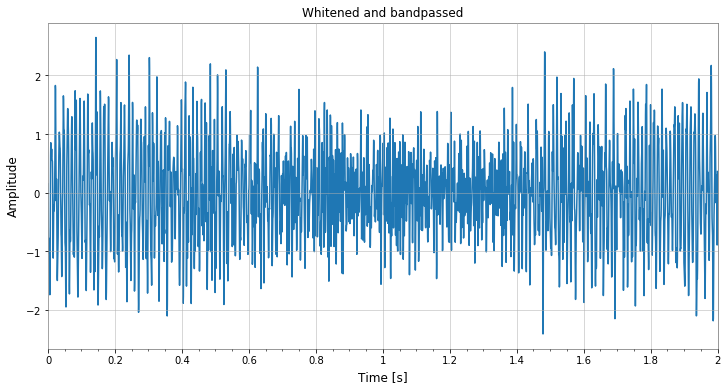

In [ ]:
white_data = d1.whiten(window=("tukey",0.2)) # whiten-function has a built-in window function
bp_data = white_data.bandpass(35, 350) # frequency range 35-350Hz
fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title('Whitened and bandpassed')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude');

Now, we have a preprocessed data that is ready for further analysis. A function that combines all the steps above and outputs preprocessed data has already been defined in one of the above cells. So we'll us that function here in the next step.

## Q-Transform
The Q-Transform is related to the Fourier transform, and very closely related to a wavelet transform. The spectrogram is a good candidate as input for a CNN model.

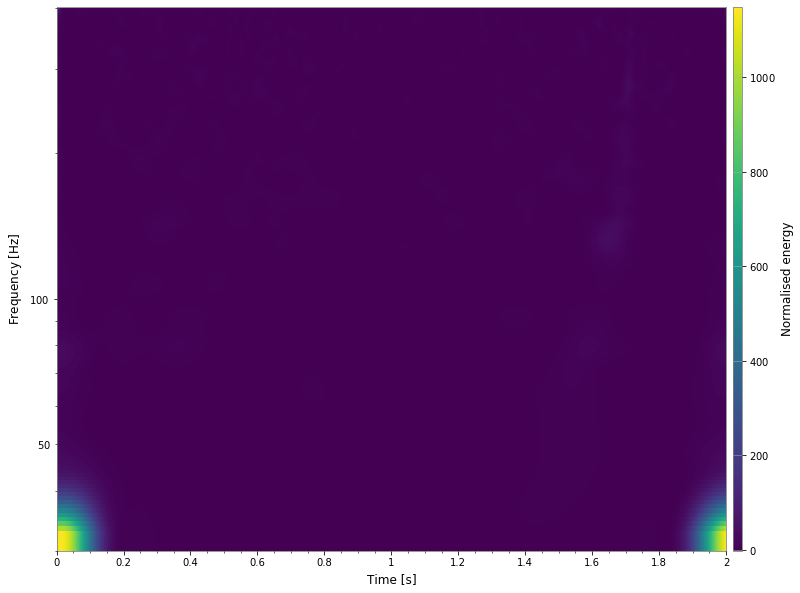

In [ ]:
r1, r2, r3 = read_file('/content/sample_data/000a5b6e5c.npy') # this signal has target=1 (has GW)
p1, p2, p3 = preprocess(r1, r2, r3)
hq = p2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

### Combine three channels into one RGB image
Since we have 3 detectors, we can combine the Q-Transforms as RGB channels into one color image. The function for that has already been defined in one of the above cells. We'll use that here:

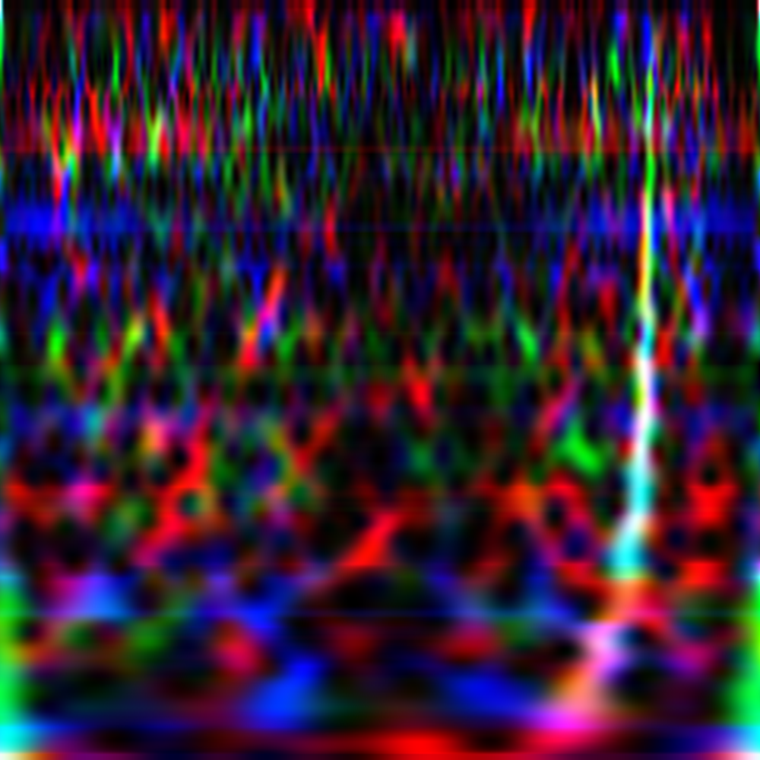

In [ ]:
create_rgb('/content/sample_data/000a5b6e5c.npy')

Here is a very obvious gravitational wave detection from the test set:

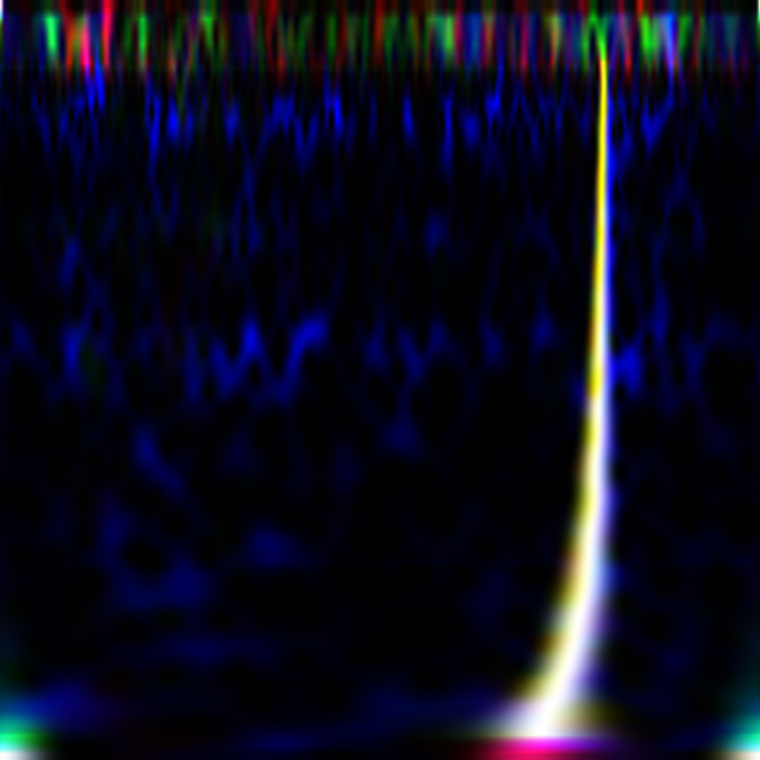

In [ ]:
create_rgb('/content/sample_data/0021f9dd71.npy')

## Create Training and Testing RGB Images

We'll use the above techniques combined to create the training images for our CNN in the next section.

Creates a folder called images which saves the RGB files. The files are separated based on label.

In [ ]:
for i,path in enumerate(train_path[]):
    pic = create_rgb(path)
    if train_labels['target'][i] == 0:
        pic.save('../images/0/' + train_labels['id'][i] + '.jpg', 'JPEG')
    elif train_labels['target'][i] == 1:
        pic.save('../images/1/' + train_labels['id'][i] + '.jpg', 'JPEG')


Create the test image files and save them.

In [ ]:
for i,path in enumerate(test_path):
    pic = create_rgb(path)
    pic.save('../test_images/' + sample_submission['id'][i] + '.jpg', 'JPEG')

Create a dataset of these images to feed to the model

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '../images/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=25,
    image_size=(256, 256),
    shuffle=True,
)

Found 560000 files belonging to 2 classes.


In [ ]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    '../test_images/',
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    batch_size=25,
    image_size=(256, 256),
    shuffle=False,
)

Found 226000 files belonging to 1 classes.


# Split the Training Dataset

During training, both training and validation sets are needed to keep track of the training process. So the training is partitioned into the validation and training sets:

In [ ]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    
    Taken from https://stackoverflow.com/a/59696126/16354660
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

train_images,val_images=split_dataset(train, .3)

# Model

Model architecture inspired by https://github.com/timothygebhard/magic-bullet

More information about EfficientNet can be found below:

*  https://arxiv.org/abs/1905.11946
*  https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html



In [ ]:
from tensorflow.keras.applications import EfficientNetB0 

model = tf.keras.Sequential(
    [L.InputLayer(input_shape=(256,256,3)),
     EfficientNetB0(input_shape=(256,256,3),weights='imagenet', include_top=False),
     L.Conv2D(16, kernel_size=2, dilation_rate=2, activation='relu', padding='same'),
     L.MaxPooling2D(pool_size=(2, 2),strides=2),
     L.Flatten(),
     L.Dense(32,activation='relu'),
     L.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          81936     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,139,764
Trainable params: 4,097,741
Non-trainable params: 42,023
_________________________________________

### Using last best checkpoint to start training

In [ ]:
import tensorflow_addons as tfa

lr_decayed_fn = tf.keras.experimental.CosineDecay(6e-4, 820*1,)
opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate=7e-4)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])

cp_filepath="bestweights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, verbose=0, save_weights_only=True, mode='max') #montior=['accuracy'],
earlystop = tf.keras.callbacks.EarlyStopping(patience=20) #monitor='accuracy',
callbacks = [earlystop, checkpoint]

In [ ]:
history=model.fit(train_images,epochs=100, steps_per_epoch=156, validation_data=val_images, validation_steps=67, verbose=1, callbacks=callbacks)

Epoch 1/100
156/156 [==============================] - 59s 332ms/step - loss: 0.6319 - auc: 0.6705 - val_loss: 0.6903 - val_auc: 0.5735
Epoch 2/100
156/156 [==============================] - 50s 321ms/step - loss: 0.5702 - auc: 0.7347 - val_loss: 0.6907 - val_auc: 0.5850
Epoch 3/100
156/156 [==============================] - 50s 320ms/step - loss: 0.5571 - auc: 0.7434 - val_loss: 0.6655 - val_auc: 0.5702
Epoch 4/100
156/156 [==============================] - 52s 337ms/step - loss: 0.5564 - auc: 0.7579 - val_loss: 0.5403 - val_auc: 0.7734
Epoch 5/100
156/156 [==============================] - 51s 330ms/step - loss: 0.5437 - auc: 0.7609 - val_loss: 0.5553 - val_auc: 0.7713
Epoch 6/100
156/156 [==============================] - 49s 317ms/step - loss: 0.5373 - auc: 0.7694 - val_loss: 0.5502 - val_auc: 0.7682
Epoch 7/100
156/156 [==============================] - 50s 321ms/step - loss: 0.5403 - auc: 0.7711 - val_loss: 0.7058 - val_auc: 0.7608
Epoch 8/100
156/156 [===========================

### Plot accuracy and loss progress

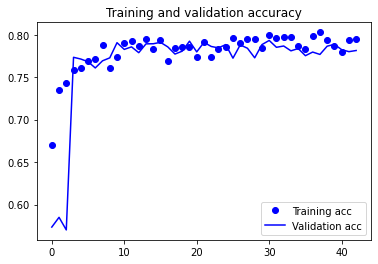

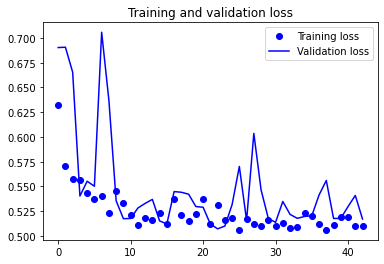

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(auc))

plt.plot(epochs, auc, 'bo', label='Training acc')
plt.plot(epochs, val_auc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Show confusion matrix

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

val_preds=[]
true=[]
for images, labels in val_images:  # create the predictions and true values for the confusion matrix
    preds=model.predict(images)
    for i,pred in enumerate(preds):
        val_preds.append((pred>.5)*1)
        true.append(labels[i].numpy())

In [ ]:
cm = confusion_matrix(true, val_preds, labels=[0,1])
print (cm)

[[78418  8152]
 [37878 49152]]


The majority of the errors came from false negatives. This makes sense, the signals are very small and very easy to miss. The model and preprocessing should be made more sensitive to reduce the false negatives.

In [ ]:
preds = model.predict(test)
preds = preds.reshape(-1)

submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})

submission.to_csv('submission.csv',index=False)